In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
file_path = r"C:\1. Power grid frequency data\AirConditioner_npv.csv"

# Read the CSV file
data = pd.read_csv(file_path)

print(data.head())


   time_s   npv      P0      V0
0       0  1.07  485.41  230.49
1      15  1.06  485.46  230.55
2      30  1.07  490.73  230.49
3      45  1.02  507.71  230.48
4      60  1.02  506.69  230.53


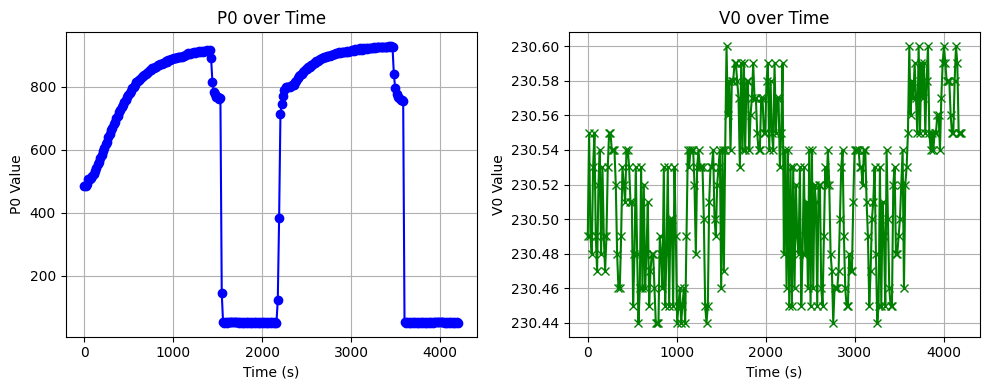

In [7]:
# Set up the side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot P0 on the first subplot
ax1.plot(data['time_s'], data['P0'], color='blue', marker='o')
ax1.set_title('P0 over Time')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('P0 Value')
ax1.grid(True)

# Plot V0 on the second subplot
ax2.plot(data['time_s'], data['V0'], color='green', marker='x')
ax2.set_title('V0 over Time')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('V0 Value')
ax2.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(


(x0)' = 29322581.059 1 + -16.568 x0 + -254372.926 x1 + 0.072 x0 x1 + 551.670 x1^2
(x1)' = 0.000


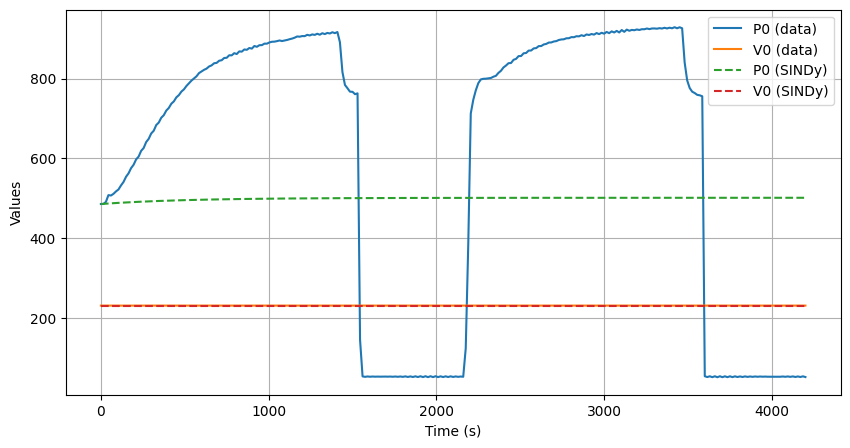

In [ ]:
time = data['time_s'].values
P0 = data['P0'].values
V0 = data['V0'].values

# Reshape P0 and V0 for SINDy 
X = np.vstack([P0, V0]).T  # Shape (n_samples, n_features)

dt = 15

# Set up SINDy with polynomial features
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=2),
                 optimizer=ps.STLSQ(threshold=0.0001))

# Fit the model
model.fit(X, t=dt)
model.print()



In [24]:
# Define a threshold for detecting mode changes (this is a simple heuristic)
mode_threshold = 100  # Customize based on data, e.g., power consumption jump

# Detect modes by changes in P0
mode_changes = np.where(np.abs(np.diff(data['P0'])) > mode_threshold)[0]

# Split data into segments for each mode
mode_segments = np.split(data, mode_changes + 1)

c:\ProjectSINDyRL\sindy_rl\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


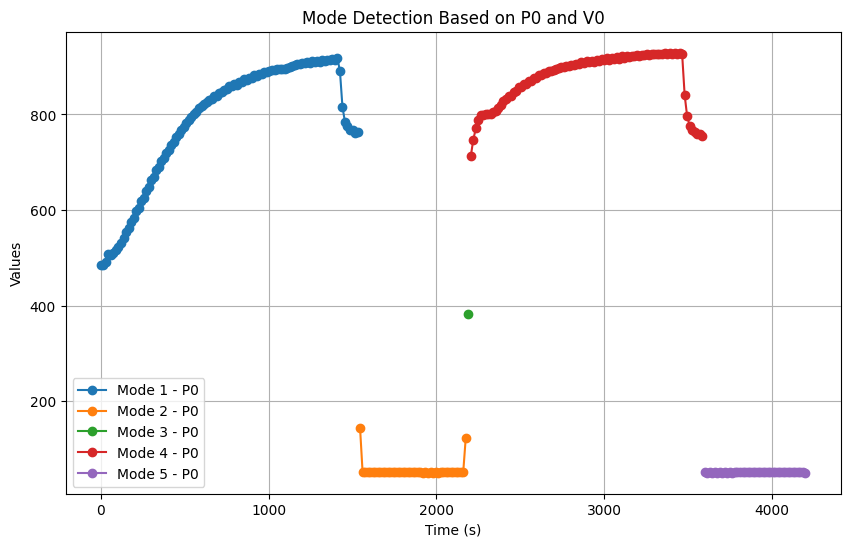

In [25]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot P0 and V0 for each mode segment
for idx, segment in enumerate(mode_segments):
    plt.plot(segment['time_s'], segment['P0'], label=f'Mode {idx+1} - P0', marker='o')
    #plt.plot(segment['time_s'], segment['V0'], label=f'Mode {idx+1} - V0', marker='x')

plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.title('Mode Detection Based on P0 and V0')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
mode_1_values = mode_segments[0] 
mode_1_values

,time_s,npv,P0,V0
0,0,1.07,485.41,230.49
1,15,1.06,485.46,230.55
2,30,1.07,490.73,230.49
3,45,1.02,507.71,230.48
4,60,1.02,506.69,230.53
...,...,...,...,...
98,1470,0.54,775.90,230.53
99,1485,0.55,767.20,230.54
100,1500,0.54,766.90,230.46
101,1515,0.58,760.95,230.54


In [6]:
# Check for NaN values in the entire DataFrame
nan_counts = df.isna().sum()

# Print the number of NaN values per column
print(nan_counts)

time_s    0
npv       1
P0        0
V0        0
dtype: int64


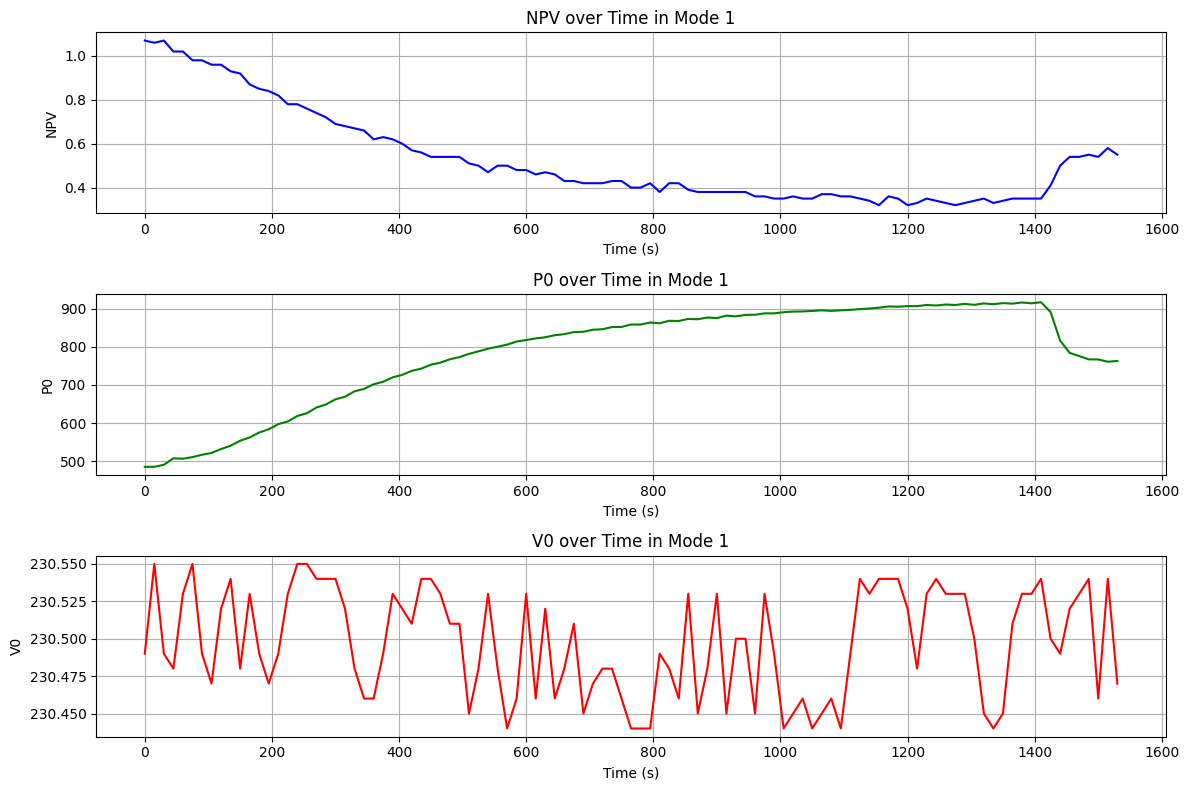

In [27]:
import matplotlib.pyplot as plt

# Assuming mode_1_values is a DataFrame and contains 'time_s', 'npv', 'P0', and 'V0'

# Plot time_s vs npv, P0, V0
plt.figure(figsize=(12, 8))

# Plot npv vs time_s
plt.subplot(3, 1, 1)  # 3 rows, 1 column, plot 1st subplot
plt.plot(mode_1_values['time_s'], mode_1_values['npv'], label='NPV', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('NPV')
plt.title('NPV over Time in Mode 1')
plt.grid(True)

# Plot P0 vs time_s
plt.subplot(3, 1, 2)  # 3 rows, 1 column, plot 2nd subplot
plt.plot(mode_1_values['time_s'], mode_1_values['P0'], label='P0', color='green')
plt.xlabel('Time (s)')
plt.ylabel('P0')
plt.title('P0 over Time in Mode 1')
plt.grid(True)

# Plot V0 vs time_s
plt.subplot(3, 1, 3)  # 3 rows, 1 column, plot 3rd subplot
plt.plot(mode_1_values['time_s'], mode_1_values['V0'], label='V0', color='red')
plt.xlabel('Time (s)')
plt.ylabel('V0')
plt.title('V0 over Time in Mode 1')
plt.grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [37]:
time = mode_1_values['time_s'].values
P0 = mode_1_values['P0'].values
V0 = mode_1_values['V0'].values

# Reshape P0 and V0 for SINDy 
X = np.vstack([P0, V0]).T  # Shape (n_samples, n_features)

dt = 15

# Set up SINDy with polynomial features
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=2),
                 optimizer=ps.STLSQ(threshold=0.001))

# Fit the model
model.fit(X, t=dt)
model.print()


(x0)' = 0.298 x0 + 0.007 x1 + -0.001 x0 x1
(x1)' = 0.000


C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(


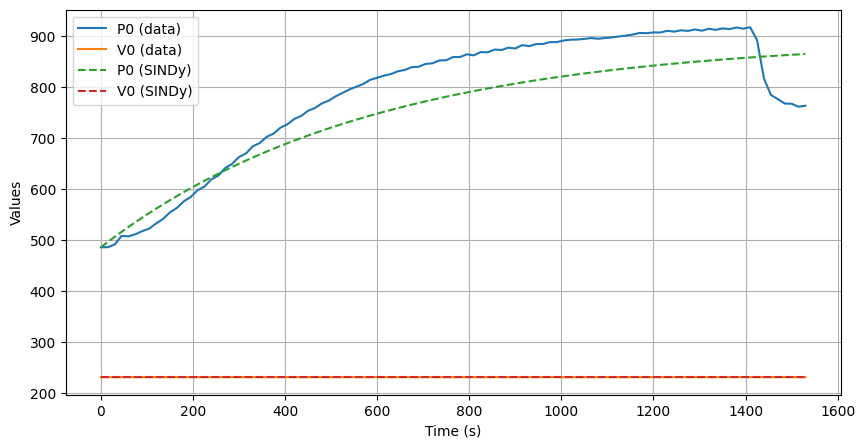

In [38]:
# Plot the results
model.simulate(X[0], time)  # Simulate starting from initial state
plt.figure(figsize=(10, 5))
plt.plot(time, P0, label='P0 (data)')
plt.plot(time, V0, label='V0 (data)')
plt.plot(time, model.simulate(X[0], time)[:, 0], '--', label='P0 (SINDy)')
plt.plot(time, model.simulate(X[0], time)[:, 1], '--', label='V0 (SINDy)')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()